# Валидация и тестирование моделей

Полезные ссылки:
- [Документация](https://scikit-learn.org/stable/modules/cross_validation.html) scikit-learn о стратегиях кроссвалидации
    - Примечание: в документации есть небольшая путаница в терминах. Часто под "test" в коде понимается именно валидационная выборка. Мы будем называть "тестовой" именно ту выборку, на которой проводится **финальная** оценка избранных моделей, а разбиения в кроссвалидации будем называть **тренировочной** и **валидационной** выборками
- Отличный [ноутбук](https://colab.research.google.com/drive/1gLvFrvAXblD4jmfHmIkkdd-balXqz0Go?usp=sharing) от Дмитрия Пензара по теме с отличными примерами

# Задание 1. Правильное разбиение данных

В этом задании не будет кода, но иногда самые важные вещи происходят без него, даже в машинном обучении. Подумайте и подробно опишите, какой способ валидации будет корректен в следующих случаях:

1. Вы строите модель предсказания температуры в прошлом, используя данные, полученные из ледяных кернов.
2. Ваша задача – разработать правила, по которым клиентам медицинской компании будет делаться заключение о том нормальные ли у них значения лабораторных анализов, превышают они норму или снижены. Компания работает в 3 регионах России, из которых вам предоставили данные по 10000, 3000 и 1000 пациентам.
3. Косметологическая компания заказала у вас исследование зависимости качества кожи от рациона питания. Они предоставили вам данные по продуктам, потребляемым в течение недели, а также численную оценку качества кожи по 100-балльной шкале для 450 людей. 200 человек проживают в Москве, 150 – во Владивостоке, а 100 – в Якутске.
4. Вы строите модель, предсказывающую возраст человека, по данным активности генов в клетках периферической крови 982 человек. Все доноры принадлежат к одной популяции и в момент проведения исследования не страдают острыми или хроническими заболеваниями в тяжёлых стадиях.

# Задание 2. Выбор модели на примере предсказания индекса счастья страны
Скачайте датасет [World Happiness Report](https://www.kaggle.com/datasets/unsdsn/world-happiness) с платформы Kaggle. Эти данные содержат информацию о различных экономических и социальных метриках для стран мира. Будем работать с 2017 годом

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [45]:
df = pd.read_csv("data/happiness/2017.csv")
df.drop(["Whisker.high", "Whisker.low"], axis="columns", inplace=True)
df

,Country,Happiness.Rank,Happiness.Score,Economy..GDP.per.Capita.,Family,Health..Life.Expectancy.,Freedom,Generosity,Trust..Government.Corruption.,Dystopia.Residual
0,Norway,1,7.537,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2.277027
1,Denmark,2,7.522,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,2.313707
2,Iceland,3,7.504,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,2.322715
3,Switzerland,4,7.494,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,2.276716
4,Finland,5,7.469,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,2.430182
...,...,...,...,...,...,...,...,...,...,...
150,Rwanda,151,3.471,0.368746,0.945707,0.326425,0.581844,0.252756,0.455220,0.540061
151,Syria,152,3.462,0.777153,0.396103,0.500533,0.081539,0.493664,0.151347,1.061574
152,Tanzania,153,3.349,0.511136,1.041990,0.364509,0.390018,0.354256,0.066035,0.621130
153,Burundi,154,2.905,0.091623,0.629794,0.151611,0.059901,0.204435,0.084148,1.683024


Разобьём страны по континентам. Если вы считаете более осмысленным другое разбиение, смело применяйте его :)

In [46]:
asian_countries = ["Israel", "United Arab Emirates", "Singapore", "Thailand", "Taiwan Province of China",
                   "Qatar", "Saudi Arabia", "Kuwait", "Bahrain", "Malaysia", "Uzbekistan", "Japan",
                   "South Korea", "Turkmenistan", "Kazakhstan", "Turkey", "Hong Kong S.A.R., China", "Philippines",
                   "Jordan", "China", "Pakistan", "Indonesia", "Azerbaijan", "Lebanon", "Vietnam",
                   "Tajikistan", "Bhutan", "Kyrgyzstan", "Nepal", "Mongolia", "Palestinian Territories",
                   "Iran", "Bangladesh", "Myanmar", "Iraq", "Sri Lanka", "Armenia", "India", "Georgia",
                   "Cambodia", "Afghanistan", "Yemen", "Syria"]
european_countries = ["Norway", "Denmark", "Iceland", "Switzerland", "Finland",
                      "Netherlands", "Sweden", "Austria", "Ireland", "Germany",
                      "Belgium", "Luxembourg", "United Kingdom", "Czech Republic",
                      "Malta", "France", "Spain", "Slovakia", "Poland", "Italy",
                      "Russia", "Lithuania", "Latvia", "Moldova", "Romania",
                      "Slovenia", "North Cyprus", "Cyprus", "Estonia", "Belarus",
                      "Serbia", "Hungary", "Croatia", "Kosovo", "Montenegro",
                      "Greece", "Portugal", "Bosnia and Herzegovina", "Macedonia",
                      "Bulgaria", "Albania", "Ukraine"]
north_american_countries = ["Canada", "Costa Rica", "United States", "Mexico",
                            "Panama", "Trinidad and Tobago", "El Salvador", "Belize", "Guatemala",
                            "Jamaica", "Nicaragua", "Dominican Republic", "Honduras",
                            "Haiti"]
south_american_countries = ["Chile", "Brazil", "Argentina", "Uruguay",
                            "Colombia", "Ecuador", "Bolivia", "Peru",
                            "Paraguay", "Venezuela"]
australian_countries = ["New Zealand", "Australia"]

# Assigning continents based on the country
df["Continent"] = "Africa"
df.loc[df["Country"].isin(asian_countries), "Continent"] = "Asia"
df.loc[df["Country"].isin(european_countries), "Continent"] = "Europe"
df.loc[df["Country"].isin(north_american_countries), "Continent"] = "North America"
df.loc[df["Country"].isin(south_american_countries), "Continent"] = "South America"
df.loc[df["Country"].isin(australian_countries), "Continent"] = "Australia"

In [47]:
df

,Country,Happiness.Rank,Happiness.Score,Economy..GDP.per.Capita.,Family,Health..Life.Expectancy.,Freedom,Generosity,Trust..Government.Corruption.,Dystopia.Residual,Continent
0,Norway,1,7.537,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2.277027,Europe
1,Denmark,2,7.522,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,2.313707,Europe
2,Iceland,3,7.504,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,2.322715,Europe
3,Switzerland,4,7.494,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,2.276716,Europe
4,Finland,5,7.469,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,2.430182,Europe
...,...,...,...,...,...,...,...,...,...,...,...
150,Rwanda,151,3.471,0.368746,0.945707,0.326425,0.581844,0.252756,0.455220,0.540061,Africa
151,Syria,152,3.462,0.777153,0.396103,0.500533,0.081539,0.493664,0.151347,1.061574,Asia
152,Tanzania,153,3.349,0.511136,1.041990,0.364509,0.390018,0.354256,0.066035,0.621130,Africa
153,Burundi,154,2.905,0.091623,0.629794,0.151611,0.059901,0.204435,0.084148,1.683024,Africa


Заметим, что уровень счастья сильно варьируется по регионам:

<Axes: xlabel='Continent', ylabel='Happiness.Score'>

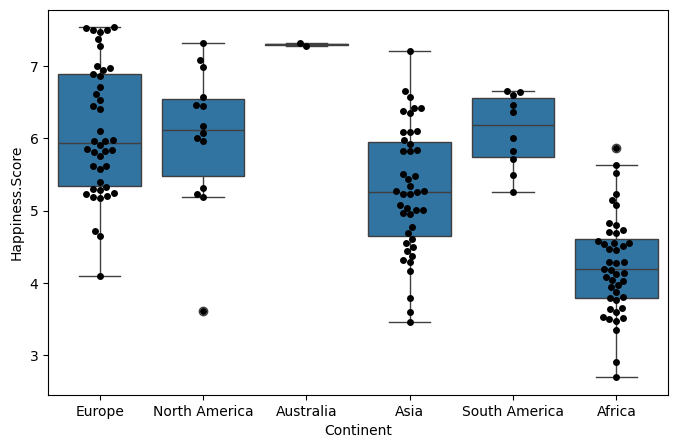

In [48]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="Continent", y="Happiness.Score")
sns.swarmplot(data=df, x="Continent", y="Happiness.Score", color="black")

**Создайте как можно лучшую модель предсказания индекса счастья по остальным числовым признакам**. 
- Подберите оптимальные гиперпараметры модели при помощи случайного поиска и поиском по сетке
- Сравните, отличаются ли оптимальные значения гиперпараметров, и в каком случае качество модели на валидации получается лучше
- Выбор валидации и модели остаётся за вами :) Ниже пример со случайной валидацией на 5 фолдов и случайным лесом
- \* Бонусное задание: примените [Optuna](https://github.com/optuna/optuna) для поиска гиперпараметров или подбора модели

In [55]:
forest = RandomForestRegressor()

# Зададим возможные значения гиперпараметров. Вы вольны добавлять другие гиперпараметры и менять значения!
param_grid = {
    "n_estimators": [10, 30, 100],
    "max_depth": [1, 10, 30],
}

cv_kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Выполним поиск по сетке GridSearchCV with KFold
grid_search_kfold = GridSearchCV(
    estimator=forest, param_grid=param_grid, cv=cv_kfold, scoring='neg_mean_squared_error')

grid_search_kfold.fit(X, y)
print("KFold CV - Best parameters:", grid_search_kfold.best_params_)
print("KFold CV - Best score:", grid_search_kfold.best_score_)

KFold CV - Best parameters: {'max_depth': 10, 'n_estimators': 30}
KFold CV - Best score: -0.014522843842061253


Если интересно посмотреть на все запуски:

In [54]:
# For KFold CV results
kfold_results = grid_search_kfold.cv_results_
print("KFold CV Results:")
for i in range(len(kfold_results['rank_test_score'])):
    print(f"Rank: {kfold_results['rank_test_score'][i]}, "
          f"Params: {kfold_results['params'][i]}, "
          f"Mean Score: {kfold_results['mean_test_score'][i]}, "
          f"Std Dev: {kfold_results['std_test_score'][i]}")

KFold CV Results:
Rank: 217, Params: {'max_depth': 1, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 10}, Mean Score: nan, Std Dev: nan
Rank: 217, Params: {'max_depth': 1, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 30}, Mean Score: nan, Std Dev: nan
Rank: 217, Params: {'max_depth': 1, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 100}, Mean Score: nan, Std Dev: nan
Rank: 206, Params: {'max_depth': 1, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}, Mean Score: -0.034374987992803564, Std Dev: 0.009605559431730613
Rank: 209, Params: {'max_depth': 1, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 30}, Mean Score: -0.035033800000165725, Std Dev: 0.008404756428300486
Rank: 210, Params: {'max_depth': 1, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}, Mean Score: -0.0354620

Заметьте, что поиск по сетке старается *максимизировать* метрику. Поэтому чтобы выбрать модель с *наименьшей* ошибкой метрика домножается на -1. Тогда чем больше мы получаем число, тем меньше ошибка и лучше модель

<Axes: >

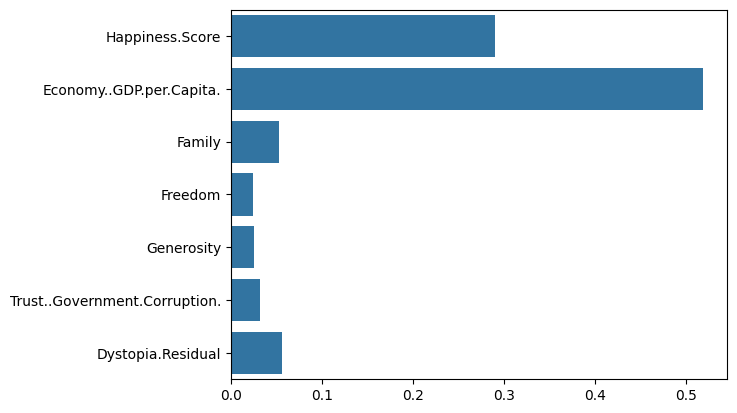

In [74]:
sns.barplot(
    x=grid_search_kfold.best_estimator_.feature_importances_,
    y=grid_search_kfold.best_estimator_.feature_names_in_,
    orient="h"
)

Как вы считаете, можем ли мы доверять этой модели? Как можно это проверить?

<Axes: xlabel='Continent', ylabel='Health..Life.Expectancy.'>

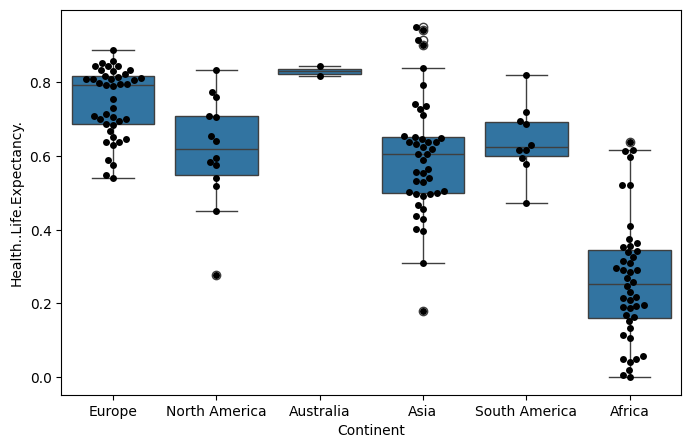

In [56]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="Continent", y="Health..Life.Expectancy.")
sns.swarmplot(data=df, x="Continent", y="Health..Life.Expectancy.", color="black")

In [69]:
x_data = df[df.columns[2: -1]]
X = x_data.drop("Health..Life.Expectancy.", axis= 1)
y = df["Health..Life.Expectancy."]
y.isnull().values.any()

False

KFold CV - Best parameters: {'max_depth': 30, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
KFold CV - Best score: -0.014594786725378176


<Axes: >

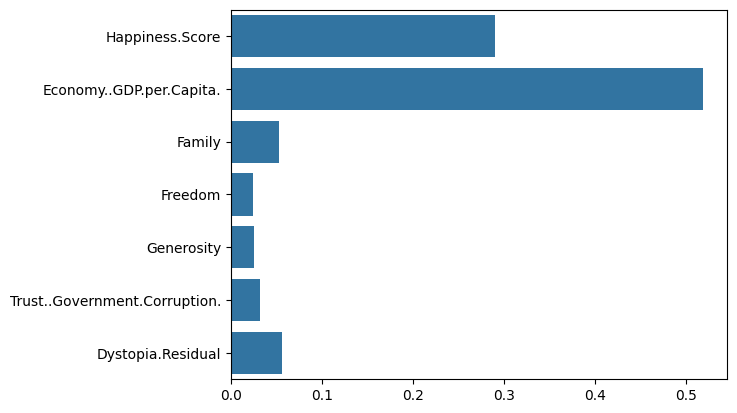

In [73]:
forest = RandomForestRegressor()

# Зададим возможные значения гиперпараметров. Вы вольны добавлять другие гиперпараметры и менять значения!
param_grid = {
    "n_estimators": [10, 30, 100],
    "max_depth": [1, 10, 30],
    'max_features':[1,3,5,7],
    'min_samples_leaf':[1,2,3],
    'min_samples_split':[2,3]
}

cv_kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Выполним поиск по сетке GridSearchCV with KFold
grid_search_kfold = GridSearchCV(
    estimator=forest, param_grid=param_grid, cv=cv_kfold, scoring='neg_mean_squared_error')

grid_search_kfold.fit(X, y)
print("KFold CV - Best parameters:", grid_search_kfold.best_params_)
print("KFold CV - Best score:", grid_search_kfold.best_score_)
sns.barplot(
    x=grid_search_kfold.best_estimator_.feature_importances_,
    y=grid_search_kfold.best_estimator_.feature_names_in_,
    orient="h"
)

In [90]:
# random search cv
rs_space={'max_depth':list(np.arange(10, 100, step=10)) + [None],
              'n_estimators':np.arange(10, 500, step=50),
              #'max_features':np.random.randint(1,7),
              'criterion':['poisson', 'absolute_error', 'friedman_mse', 'squared_error'],
              #'min_samples_leaf':np.random.randint(1,4),
              'min_samples_split':np.arange(2, 10, step=2)
          }

rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(rf, rs_space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=3)
model_random = rf_random.fit(X,y)

# random random search results
print('Best random search hyperparameters are: '+str(model_random.best_params_))
print('Best random search score is: '+str(model_random.best_score_))

C:\progs\WPy64-3940\Python_files\blastim\blast_env\lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan na

Best random search hyperparameters are: {'n_estimators': 160, 'min_samples_split': 6, 'max_depth': 30, 'criterion': 'poisson'}
Best random search score is: nan
